**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**DataGen for Train and Valid**

In [ ]:
import cv2
import random

SIZE = 512

def data_gen(img_folder, mask_folder, batch_size):
  c = 0
  n = os.listdir(img_folder) #List of training images
  random.shuffle(n)
  
  while (True):
    img = np.zeros((batch_size, SIZE, SIZE, 3)).astype('float')
    mask = np.zeros((batch_size, SIZE, SIZE, 1)).astype('float')

    for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

      train_img = cv2.imread(img_folder+'/'+n[i])/255.
      train_img =  cv2.resize(train_img, (SIZE, SIZE))# Read an image from folder and resize
      
      img[i-c] = train_img #add to array - img[0], img[1], and so on.
                                                   

      train_mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)/255.
      train_mask = cv2.resize(train_mask, (SIZE, SIZE))
      train_mask = train_mask.reshape(SIZE, SIZE, 1) # Add extra dimension for parity with train_img size [SIZE * SIZE * 3]

      mask[i-c] = train_mask

    c+=batch_size
    if(c+batch_size>=len(os.listdir(img_folder))):
      c=0
      random.shuffle(n)
                  # print "randomizing again"
    yield img, mask




train_frame_path = '/content/drive/My Drive/mass_roads/train/mod_sat'
train_mask_path = '/content/drive/My Drive/mass_roads/train/mod_map'

val_frame_path = '/content/drive/My Drive/mass_roads/test/mod_sat'
val_mask_path = '/content/drive/My Drive/mass_roads/test/mod_map'

# Train the model
train_gen = data_gen(train_frame_path,train_mask_path, batch_size = 8)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = 8)

print('Done')

Done


**Imports**

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


Using TensorFlow backend.


**Parameters**

In [ ]:
NO_OF_TRAINING_IMAGES = len(os.listdir('/content/drive/My Drive/mass_roads/train/mod_sat'))
NO_OF_VAL_IMAGES = len(os.listdir('/content/drive/My Drive/mass_roads/test/mod_sat'))

NO_OF_EPOCHS = 99

BATCH_SIZE = 16

print(NO_OF_TRAINING_IMAGES)
print(NO_OF_VAL_IMAGES)
print(BATCH_SIZE)


4432
196
16


In [ ]:
#ignore for now
checkpoint = ModelCheckpoint(weights_path, monitor='METRIC_TO_MONITOR', 
                             verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger('./log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'METRIC_TO_MONITOR', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]



**Model Architecture**

In [ ]:
def get_unet(rows, cols):
    inputs = Input((rows, cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-5), loss = 'binary_crossentropy')

    return model


In [ ]:
m = get_unet(SIZE, SIZE)
m.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
_____________________________________

**Training**

In [ ]:
#started at 9.50 am
results = m.fit_generator(train_gen, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_gen, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE) 
                          )


import datetime
s = 'MODEL_EPOCHS = ' + str(NO_OF_EPOCHS) + '_TRAINING IMAGES = ' + str(NO_OF_TRAINING_IMAGES) + '_' + str(datetime.datetime.now())  +'.h5' 
m.save(s)
m.save('/content/drive/My Drive/99_final_epochs_trained_model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/99
277/277 [==============================] - 2861s 10s/step - loss: 0.4457 - val_loss: 0.2352
Epoch 2/99
277/277 [==============================] - 2858s 10s/step - loss: 0.2200 - val_loss: 0.2132
Epoch 3/99
277/277 [==============================] - 179s 647ms/step - loss: 0.1854 - val_loss: 0.1778
Epoch 4/99
277/277 [==============================] - 184s 666ms/step - loss: 0.1784 - val_loss: 0.1722
Epoch 5/99
277/277 [==============================] - 185s 669ms/step - loss: 0.1756 - val_loss: 0.1741
Epoch 6/99
277/277 [==============================] - 186s 670ms/step - loss: 0.1713 - val_loss: 0.1651
Epoch 7/99
277/277 [==============================] - 185s 669ms/step - loss: 0.1692 - val_loss: 0.1653
Epoch 8/99
277/277 [==============================] - 185s 670ms/step - loss: 0.1690 - val_loss: 0.1576
Epoch 9/99
277/277 [==============================] - 186s 670ms/step - loss: 0.1615 - val_loss: 0.1402
Epoch 10/99
277/27

**Prediction**

In [ ]:
new_model = load_model('/content/drive/My Drive/40_final_trained_model.h5')

Instructions for updating:
Use tf.cast instead.


In [ ]:
import cv2

test_img = cv2.imread('/content/drive/My Drive/mass_roads/valid/mod_sat/10978795_15_2.tif')/255.
test_img =  cv2.resize(test_img, (SIZE, SIZE))
test_img.shape

(512, 512, 3)

In [ ]:
test_img = np.array([test_img])
test_img.shape

(1, 512, 512, 3)

In [ ]:
#Cslling the predict function on Numpy Image Array
b = new_model.predict(test_img, batch_size = None, verbose = 0, steps = None)


In [ ]:
 data = b[0]*255
data = np.floor(data)
print(data)
data = np.squeeze(data, axis=(2,))

[[[66.]
  [50.]
  [34.]
  ...
  [28.]
  [38.]
  [75.]]

 [[49.]
  [25.]
  [16.]
  ...
  [ 7.]
  [17.]
  [42.]]

 [[31.]
  [16.]
  [ 8.]
  ...
  [ 4.]
  [ 7.]
  [26.]]

 ...

 [[45.]
  [39.]
  [31.]
  ...
  [ 2.]
  [ 7.]
  [24.]]

 [[62.]
  [62.]
  [42.]
  ...
  [ 7.]
  [11.]
  [33.]]

 [[88.]
  [68.]
  [57.]
  ...
  [20.]
  [29.]
  [64.]]]


In [ ]:
#Thresholding
data_threshold = (data > 35)*1
data_threshold.astype(np.int)
data_threshold = data_threshold*255
print (data_threshold)






[[255 255   0 ...   0 255 255]
 [255   0   0 ...   0   0 255]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0 255]]


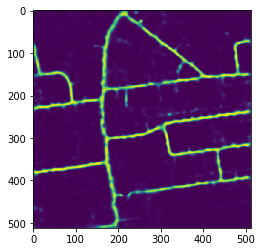

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(data)
plt.show()


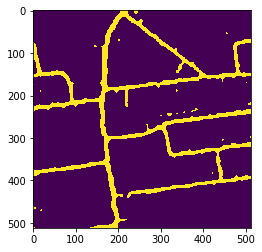

In [ ]:
plt.imshow(data_threshold)
plt.show()